In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [15]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [13]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [7]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [8]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_happy.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_happy.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [16]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...

Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_9 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 2209s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5100 - loss: 0.6930
Epoch 1: val_accuracy improved from -inf to 0.50175, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5017 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5733 - loss: 0.6913
Epoch 2: val_accuracy improved from 0.50175 to 0.67525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5733 - loss: 0.6913 - val_accuracy: 0.6752 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6666 - loss: 0.6775
Epoch 3: val_accuracy did not improve from 0.67525
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6667 - loss: 0.6775 - val_accuracy: 0.6133 - val_loss: 0.6341 - learning_rate: 1.0000e-04
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7673 - loss: 0.6008
Epoch 4: val_accuracy improved from 0.67525 to 0.70525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7674 - loss: 0.6007 - val_accuracy: 0.7053 - val_loss: 0.5067 - learning_rate: 1.0000e-04
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8618 - loss: 0.4229
Epoch 5: val_accuracy improved from 0.70525 to 0.77250, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8618 - loss: 0.4229 - val_accuracy: 0.7725 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8839 - loss: 0.3089
Epoch 6: val_accuracy improved from 0.77250 to 0.91275, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8839 - loss: 0.3089 - val_accuracy: 0.9128 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 7/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8911 - loss: 0.2716
Epoch 7: val_accuracy improved from 0.91275 to 0.91525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8911 - loss: 0.2716 - val_accuracy: 0.9153 - val_loss: 0.2288 - learning_rate: 1.0000e-04
Epoch 8/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8903 - loss: 0.2616
Epoch 8: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8903 - loss: 0.2616 - val_accuracy: 0.9105 - val_loss: 0.2275 - learning_rate: 1.0000e-04
Epoch 9/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8996 - loss: 0.2568
Epoch 9: val_accuracy did not improve from 0.91525
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8996 - loss: 0.2568 - val_accuracy: 0.9100 - val_loss: 0.2239 - learning_rate: 1.0000e-04
Epoch 10/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8951 - loss: 0.2544
Epoch 10: val_accuracy improved from 0.91525 to 0.92450, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8951 - loss: 0.2544 - val_accuracy: 0.9245 - val_loss: 0.2061 - learning_rate: 1.0000e-04
Epoch 11/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9017 - loss: 0.2497
Epoch 11: val_accuracy did not improve from 0.92450
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9017 - loss: 0.2497 - val_accuracy: 0.9245 - val_loss: 0.2034 - learning_rate: 1.0000e-04
Epoch 12/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9055 - loss: 0.2387
Epoch 12: val_accuracy improved from 0.92450 to 0.92700, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9054 - loss: 0.2387 - val_accuracy: 0.9270 - val_loss: 0.2005 - learning_rate: 1.0000e-04
Epoch 13/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9054 - loss: 0.2420
Epoch 13: val_accuracy did not improve from 0.92700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9054 - loss: 0.2420 - val_accuracy: 0.9262 - val_loss: 0.2061 - learning_rate: 1.0000e-04
Epoch 14/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8954 - loss: 0.2519
Epoch 14: val_accuracy did not improve from 0.92700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8954 - loss: 0.2519 - val_accuracy: 0.9180 - val_loss: 0.2089 - learning_rate: 1.0000e-04
Epoch 15/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9059 - loss: 0.2340
Epoch 15: val_accuracy did not improve from 0.92700
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9059 - loss: 0.2340 - val_accuracy: 0.8988 - val_loss: 0.2354 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8994 - loss: 0.2416 - val_accuracy: 0.9295 - val_loss: 0.1911 - learning_rate: 1.0000e-04
Epoch 17/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9041 - loss: 0.2340
Epoch 17: val_accuracy improved from 0.92950 to 0.93225, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9041 - loss: 0.2340 - val_accuracy: 0.9323 - val_loss: 0.1888 - learning_rate: 1.0000e-04
Epoch 18/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9069 - loss: 0.2415
Epoch 18: val_accuracy did not improve from 0.93225
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9069 - loss: 0.2415 - val_accuracy: 0.9247 - val_loss: 0.1946 - learning_rate: 1.0000e-04
Epoch 19/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9099 - loss: 0.2274
Epoch 19: val_accuracy improved from 0.93225 to 0.93325, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9099 - loss: 0.2274 - val_accuracy: 0.9333 - val_loss: 0.1868 - learning_rate: 1.0000e-04
Epoch 20/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9116 - loss: 0.2251
Epoch 20: val_accuracy did not improve from 0.93325
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9116 - loss: 0.2251 - val_accuracy: 0.9323 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 21/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9079 - loss: 0.2308
Epoch 21: val_accuracy improved from 0.93325 to 0.93650, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9079 - loss: 0.2307 - val_accuracy: 0.9365 - val_loss: 0.1809 - learning_rate: 1.0000e-04
Epoch 22/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9084 - loss: 0.2232
Epoch 22: val_accuracy did not improve from 0.93650
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9084 - loss: 0.2232 - val_accuracy: 0.9365 - val_loss: 0.1773 - learning_rate: 1.0000e-04
Epoch 23/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9132 - loss: 0.2209
Epoch 23: val_accuracy did not improve from 0.93650
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9132 - loss: 0.2210 - val_accuracy: 0.9233 - val_loss: 0.1936 - learning_rate: 1.0000e-04
Epoch 24/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9131 - loss: 0.2180
Epoch 24: val_accuracy did not improve from 0.93650
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9131 - loss: 0.2180 - val_accuracy: 0.9337 - val_loss: 0.1751 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9171 - loss: 0.2145 - val_accuracy: 0.9427 - val_loss: 0.1687 - learning_rate: 1.0000e-04
Epoch 29/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9171 - loss: 0.2126
Epoch 29: val_accuracy did not improve from 0.94275
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9171 - loss: 0.2126 - val_accuracy: 0.9190 - val_loss: 0.1985 - learning_rate: 1.0000e-04
Epoch 30/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9152 - loss: 0.2124
Epoch 30: val_accuracy did not improve from 0.94275
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9153 - loss: 0.2124 - val_accuracy: 0.9427 - val_loss: 0.1598 - learning_rate: 1.0000e-04
Epoch 31/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9144 - loss: 0.2082
Epoch 31: val_accuracy did not improve from 0.94275
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9144 - loss: 0.2082 - val_accuracy: 0.9323 - val_loss: 0.1707 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9189 - loss: 0.2044 - val_accuracy: 0.9467 - val_loss: 0.1564 - learning_rate: 1.0000e-04
Epoch 33/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9184 - loss: 0.2055
Epoch 33: val_accuracy did not improve from 0.94675
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9184 - loss: 0.2055 - val_accuracy: 0.9445 - val_loss: 0.1538 - learning_rate: 1.0000e-04
Epoch 34/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9276 - loss: 0.1906
Epoch 34: val_accuracy improved from 0.94675 to 0.95000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9276 - loss: 0.1907 - val_accuracy: 0.9500 - val_loss: 0.1524 - learning_rate: 1.0000e-04
Epoch 35/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9223 - loss: 0.1978
Epoch 35: val_accuracy did not improve from 0.95000
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9223 - loss: 0.1977 - val_accuracy: 0.9470 - val_loss: 0.1477 - learning_rate: 1.0000e-04
Epoch 36/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9227 - loss: 0.1911
Epoch 36: val_accuracy did not improve from 0.95000
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9227 - loss: 0.1911 - val_accuracy: 0.9477 - val_loss: 0.1456 - learning_rate: 1.0000e-04
Epoch 37/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9274 - loss: 0.1910
Epoch 37: val_accuracy did not improve from 0.95000
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9274 - loss: 0.1910 - val_accuracy: 0.9492 - val_loss: 0.1435 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9303 - loss: 0.1810 - val_accuracy: 0.9548 - val_loss: 0.1427 - learning_rate: 1.0000e-04
Epoch 41/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9258 - loss: 0.1902
Epoch 41: val_accuracy did not improve from 0.95475
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9258 - loss: 0.1902 - val_accuracy: 0.9247 - val_loss: 0.1906 - learning_rate: 1.0000e-04
Epoch 42/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9345 - loss: 0.1781
Epoch 42: val_accuracy did not improve from 0.95475
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9345 - loss: 0.1781 - val_accuracy: 0.9438 - val_loss: 0.1646 - learning_rate: 1.0000e-04
Epoch 43/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9318 - loss: 0.1796
Epoch 43: val_accuracy did not improve from 0.95475
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9318 - loss: 0.1797 - val_accuracy: 0.9517 - val_loss: 0.1381 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9348 - loss: 0.1751 - val_accuracy: 0.9578 - val_loss: 0.1212 - learning_rate: 1.0000e-04
Epoch 47/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9321 - loss: 0.1764
Epoch 47: val_accuracy improved from 0.95775 to 0.96050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9322 - loss: 0.1764 - val_accuracy: 0.9605 - val_loss: 0.1239 - learning_rate: 1.0000e-04
Epoch 48/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9394 - loss: 0.1627
Epoch 48: val_accuracy did not improve from 0.96050
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9394 - loss: 0.1627 - val_accuracy: 0.9582 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 49/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9394 - loss: 0.1583
Epoch 49: val_accuracy did not improve from 0.96050
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9394 - loss: 0.1583 - val_accuracy: 0.9595 - val_loss: 0.1142 - learning_rate: 1.0000e-04
Epoch 50/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9393 - loss: 0.1552
Epoch 50: val_accuracy improved from 0.96050 to 0.96125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9393 - loss: 0.1552 - val_accuracy: 0.9613 - val_loss: 0.1121 - learning_rate: 1.0000e-04
Epoch 51/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9380 - loss: 0.1604
Epoch 51: val_accuracy did not improve from 0.96125
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9380 - loss: 0.1604 - val_accuracy: 0.9580 - val_loss: 0.1264 - learning_rate: 1.0000e-04
Epoch 52/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9370 - loss: 0.1708
Epoch 52: val_accuracy improved from 0.96125 to 0.96350, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9370 - loss: 0.1707 - val_accuracy: 0.9635 - val_loss: 0.1082 - learning_rate: 1.0000e-04
Epoch 53/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9397 - loss: 0.1606
Epoch 53: val_accuracy improved from 0.96350 to 0.96450, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9397 - loss: 0.1606 - val_accuracy: 0.9645 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 54/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9421 - loss: 0.1526
Epoch 54: val_accuracy did not improve from 0.96450
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9421 - loss: 0.1527 - val_accuracy: 0.9560 - val_loss: 0.1284 - learning_rate: 1.0000e-04
Epoch 55/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9411 - loss: 0.1611
Epoch 55: val_accuracy did not improve from 0.96450
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9411 - loss: 0.1611 - val_accuracy: 0.9645 - val_loss: 0.1071 - learning_rate: 1.0000e-04
Epoch 56/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9443 - loss: 0.1454
Epoch 56: val_accuracy improved from 0.96450 to 0.96575, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9443 - loss: 0.1454 - val_accuracy: 0.9657 - val_loss: 0.1038 - learning_rate: 1.0000e-04
Epoch 57/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9411 - loss: 0.1602
Epoch 57: val_accuracy did not improve from 0.96575
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9411 - loss: 0.1602 - val_accuracy: 0.9592 - val_loss: 0.1227 - learning_rate: 1.0000e-04
Epoch 58/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9413 - loss: 0.1587
Epoch 58: val_accuracy improved from 0.96575 to 0.96675, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9413 - loss: 0.1587 - val_accuracy: 0.9668 - val_loss: 0.1030 - learning_rate: 1.0000e-04
Epoch 59/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9474 - loss: 0.1410
Epoch 59: val_accuracy improved from 0.96675 to 0.96975, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9474 - loss: 0.1410 - val_accuracy: 0.9697 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 60/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9408 - loss: 0.1536
Epoch 60: val_accuracy improved from 0.96975 to 0.97050, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9408 - loss: 0.1536 - val_accuracy: 0.9705 - val_loss: 0.0941 - learning_rate: 1.0000e-04
Epoch 61/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9473 - loss: 0.1418
Epoch 61: val_accuracy improved from 0.97050 to 0.97125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9473 - loss: 0.1418 - val_accuracy: 0.9712 - val_loss: 0.0916 - learning_rate: 1.0000e-04
Epoch 62/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9471 - loss: 0.1417
Epoch 62: val_accuracy did not improve from 0.97125
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9471 - loss: 0.1417 - val_accuracy: 0.9712 - val_loss: 0.0906 - learning_rate: 1.0000e-04
Epoch 63/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9460 - loss: 0.1430
Epoch 63: val_accuracy improved from 0.97125 to 0.97250, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9460 - loss: 0.1429 - val_accuracy: 0.9725 - val_loss: 0.0893 - learning_rate: 1.0000e-04
Epoch 64/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9518 - loss: 0.1297
Epoch 64: val_accuracy did not improve from 0.97250
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9518 - loss: 0.1297 - val_accuracy: 0.9655 - val_loss: 0.0995 - learning_rate: 1.0000e-04
Epoch 65/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9477 - loss: 0.1409
Epoch 65: val_accuracy did not improve from 0.97250
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9477 - loss: 0.1409 - val_accuracy: 0.9650 - val_loss: 0.1119 - learning_rate: 1.0000e-04
Epoch 66/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9423 - loss: 0.1471
Epoch 66: val_accuracy improved from 0.97250 to 0.97375, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9423 - loss: 0.1471 - val_accuracy: 0.9737 - val_loss: 0.0849 - learning_rate: 1.0000e-04
Epoch 67/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9511 - loss: 0.1351
Epoch 67: val_accuracy did not improve from 0.97375
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9511 - loss: 0.1351 - val_accuracy: 0.9640 - val_loss: 0.1049 - learning_rate: 1.0000e-04
Epoch 68/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9535 - loss: 0.1239
Epoch 68: val_accuracy improved from 0.97375 to 0.97500, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9535 - loss: 0.1240 - val_accuracy: 0.9750 - val_loss: 0.0886 - learning_rate: 1.0000e-04
Epoch 69/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9472 - loss: 0.1389
Epoch 69: val_accuracy did not improve from 0.97500
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9472 - loss: 0.1389 - val_accuracy: 0.9672 - val_loss: 0.0939 - learning_rate: 1.0000e-04
Epoch 70/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9508 - loss: 0.1370
Epoch 70: val_accuracy did not improve from 0.97500

Epoch 70: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9508 - loss: 0.1370 - val_accuracy: 0.9707 - val_loss: 0.0866 - learning_rate: 1.0000e-04
Epoch 71/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9551 - loss: 0.1242
Epoch 71: val_accuracy improved from 0.97500 to 0.97600, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9551 - loss: 0.1242 - val_accuracy: 0.9760 - val_loss: 0.0809 - learning_rate: 5.0000e-05
Epoch 72/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9545 - loss: 0.1277
Epoch 72: val_accuracy did not improve from 0.97600
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9545 - loss: 0.1277 - val_accuracy: 0.9737 - val_loss: 0.0810 - learning_rate: 5.0000e-05
Epoch 73/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9550 - loss: 0.1201
Epoch 73: val_accuracy did not improve from 0.97600
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9550 - loss: 0.1201 - val_accuracy: 0.9705 - val_loss: 0.0864 - learning_rate: 5.0000e-05
Epoch 74/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9525 - loss: 0.1325
Epoch 74: val_accuracy improved from 0.97600 to 0.97625, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9525 - loss: 0.1324 - val_accuracy: 0.9762 - val_loss: 0.0830 - learning_rate: 5.0000e-05
Epoch 75/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9570 - loss: 0.1192
Epoch 75: val_accuracy did not improve from 0.97625

Epoch 75: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9570 - loss: 0.1192 - val_accuracy: 0.9710 - val_loss: 0.0852 - learning_rate: 5.0000e-05
Epoch 76/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9512 - loss: 0.1259
Epoch 76: val_accuracy improved from 0.97625 to 0.97825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9513 - loss: 0.1258 - val_accuracy: 0.9783 - val_loss: 0.0794 - learning_rate: 2.5000e-05
Epoch 77/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9563 - loss: 0.1218
Epoch 77: val_accuracy did not improve from 0.97825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9563 - loss: 0.1218 - val_accuracy: 0.9682 - val_loss: 0.0903 - learning_rate: 2.5000e-05
Epoch 78/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9571 - loss: 0.1221
Epoch 78: val_accuracy did not improve from 0.97825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9571 - loss: 0.1221 - val_accuracy: 0.9770 - val_loss: 0.0769 - learning_rate: 2.5000e-05
Epoch 79/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9605 - loss: 0.1104
Epoch 79: val_accuracy did not improve from 0.97825
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9605 - loss: 0.1104 - val_accuracy: 0.9780 - val_loss: 0.0759 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9588 - loss: 0.1168 - val_accuracy: 0.9795 - val_loss: 0.0764 - learning_rate: 2.5000e-05
Epoch 82/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9595 - loss: 0.1145
Epoch 82: val_accuracy did not improve from 0.97950
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9595 - loss: 0.1145 - val_accuracy: 0.9787 - val_loss: 0.0755 - learning_rate: 2.5000e-05
Epoch 83/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9556 - loss: 0.1198
Epoch 83: val_accuracy did not improve from 0.97950
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9556 - loss: 0.1198 - val_accuracy: 0.9772 - val_loss: 0.0753 - learning_rate: 2.5000e-05
Epoch 84/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9613 - loss: 0.1145
Epoch 84: val_accuracy did not improve from 0.97950
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9613 - loss: 0.1145 - val_accuracy: 0.9762 - val_loss: 0.0755 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9549 - loss: 0.1226 - val_accuracy: 0.9797 - val_loss: 0.0717 - learning_rate: 1.2500e-05
Epoch 98/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9587 - loss: 0.1122
Epoch 98: val_accuracy did not improve from 0.97975
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9587 - loss: 0.1122 - val_accuracy: 0.9753 - val_loss: 0.0740 - learning_rate: 1.2500e-05
Epoch 99/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9595 - loss: 0.1142
Epoch 99: val_accuracy did not improve from 0.97975
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9595 - loss: 0.1142 - val_accuracy: 0.9775 - val_loss: 0.0730 - learning_rate: 1.2500e-05
Epoch 100/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9572 - loss: 0.1147
Epoch 100: val_accuracy did not improve from 0.97975
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9572 - loss: 0.1147 - val_accuracy: 0.9772 - val_loss: 0.0726 - learning_rate

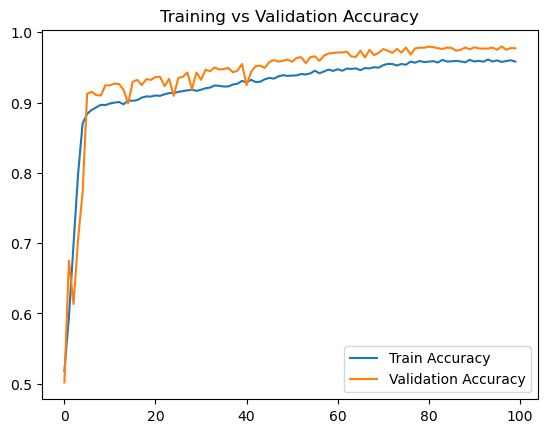

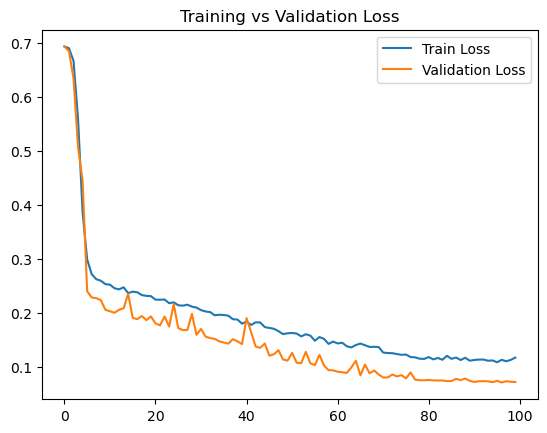

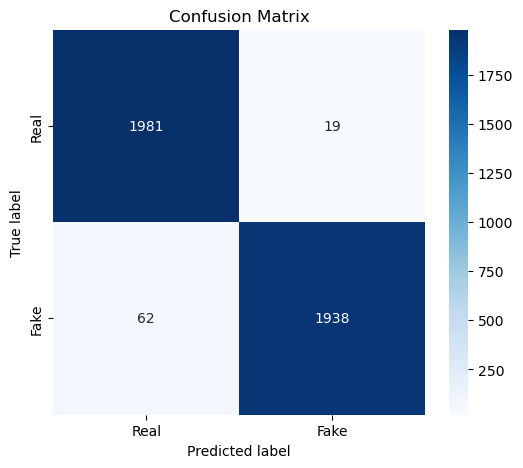

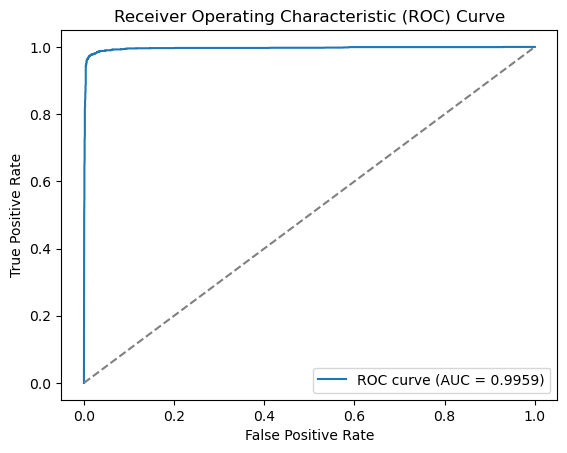

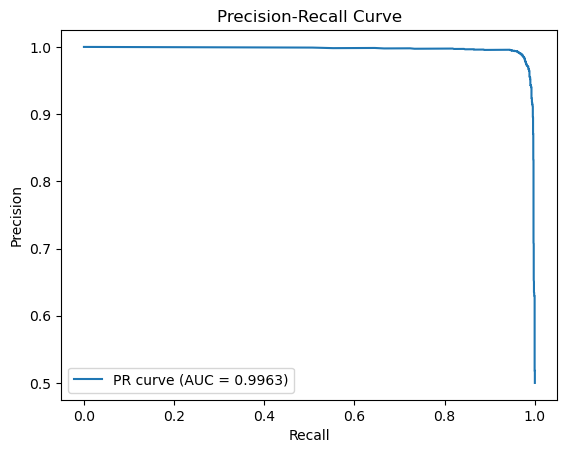

Accuracy Score: 0.9798
ROC AUC Score: 0.9959
Recall Score: 0.9690
Precision Score: 0.9903
F1 Score: 0.9795
PR AUC Score: 0.9963
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2000
           1       0.99      0.97      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [17]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)